In [1]:
import data_base as db
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter
from datetime import datetime
import time
from scipy import stats

# Сегментация клиентов (RFM-анализ)

In [2]:
#recency дней с последней покупки
#frequency общее количество транзакций (чеков)
#monetary средняя величина чека
connection, cursor = db.connect_db()
cursor.execute('''
SELECT 
    customer_id,
    MIN (TIMESTAMP '2020-03-01' - check_date) recency,
    COUNT (check_id )frequency,
    AVG (before_discount_amt) monetary
FROM bills
WHERE after_discount_amt > 0
GROUP BY 1
    
''')
result = cursor.fetchall()
db.close_connection(connection, cursor)
RFM = pd.DataFrame(result, columns = ['customer_id',
                                      'recency',
                                      'frequency',
                                      'monetary'])
RFM['recency'] = pd.to_numeric(RFM['recency'].dt.days, downcast='integer')

Database opened successfully


In [7]:
RFM.iloc[:,1:]

,recency,frequency,monetary
0,46,1,478.299988
1,28,17,408.058824
2,8,33,474.072727
3,16,8,76.250000
4,10,21,332.142857
...,...,...,...
520221,46,11,229.800000
520222,9,7,152.285714
520223,57,2,54.950001
520224,91,18,222.744443


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

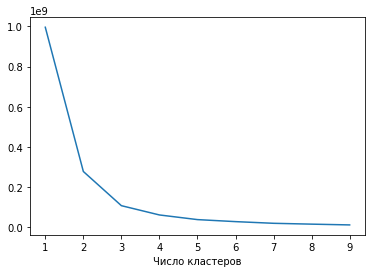

In [3]:
from sklearn.cluster import KMeans

sse=dict()
recency_cl = RFM[['recency']]
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, max_iter=1000).fit(recency_cl)
    recency_cl['clusters'] = kmeans.labels_
    sse[i] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Число кластеров')
plt.show()

In [94]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(RFM[['recency']])
RFM['RecencyCluster'] = kmeans.predict(RFM[['recency']])


def order_cluster(cluster, target, data, ascending):
    df_new = data.groupby(cluster)[target].mean().reset_index()
    df_new = df_new.sort_values(by=target,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(data,df_new[[cluster,'index']], on=cluster)
    df_final = df_final.drop([cluster],axis=1)
    df_final = df_final.rename(columns={"index":cluster})
    return df_final

RFM = order_cluster('RecencyCluster', 'recency', RFM, False)

In [95]:
RFM

,customer_id,recency,frequency,monetary,RecencyCluster
0,000021d6-2d90-43ba-8a94-1e80f2f43846-ws,46,1,478.299988,2
1,00003187-2797-47f5-9ff1-5c2a3770c03c-ws,28,17,408.058824,2
2,00018164-f4a3-4640-ad5a-793dc4c1942e-ws,42,15,646.000000,2
3,0001be5d-11e9-457c-a6e5-ce00c7e1b5bd-ws,39,3,270.600008,2
4,0001d202-f3c9-4be6-8c3f-4b3160aa4fcb-ws,37,12,296.466667,2
...,...,...,...,...,...
520221,fffd6bf9-e995-417d-b61b-af8f879f0145-ws,70,15,369.920000,1
520222,fffdd0ae-d2c6-4468-b8bf-4a2a7ccc63af-ws,71,2,204.500000,1
520223,fffee54b-deb0-42b4-aa6a-bd5a3a3ad177-ws,84,19,879.315789,1
520224,ffffde29-7d94-4f5e-96e4-e1eb3260a3ef-ws,91,18,222.744443,1


In [96]:
RFM.groupby('RecencyCluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,50863.0,147.453670,19.294358,114.0,132.0,146.0,164.0,182.0
1,90249.0,79.705415,15.140048,61.0,67.0,76.0,91.0,113.0
2,128100.0,40.450258,9.246972,26.0,32.0,40.0,47.0,60.0
3,251014.0,11.019983,6.738597,1.0,5.0,10.0,15.0,25.0


In [97]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(RFM[['frequency']])
RFM['FrequencyCluster'] = kmeans.predict(RFM[['frequency']])


RFM = order_cluster('FrequencyCluster', 'frequency',RFM,True)
RFM.groupby('FrequencyCluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,285534.0,6.391197,3.570166,1.0,3.0,6.0,9.0,13.0
1,148353.0,20.179882,4.499153,14.0,16.0,20.0,24.0,29.0
2,69457.0,39.413162,7.309888,30.0,33.0,38.0,45.0,56.0
3,16882.0,74.088260,18.777296,57.0,61.0,68.0,80.0,338.0


In [98]:
kmeans.fit(RFM[['monetary']])
RFM['MonetaryCluster'] = kmeans.predict(RFM[['monetary']])


RFM = order_cluster('MonetaryCluster', 'monetary',RFM,True)
RFM.groupby('MonetaryCluster')['monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,249741.0,177.600100,66.396489,4.300000,124.500000,173.750000,232.463158,300.325000
1,183104.0,422.561593,78.627779,300.327273,354.215380,414.533333,486.200000,580.383333
2,78530.0,737.190139,124.824886,580.399994,634.324108,705.702180,815.659375,1083.104167
3,8851.0,1426.852659,487.429024,1083.142857,1160.000000,1276.187500,1512.275000,9504.666667


In [99]:
#подсчет общего
RFM['OverallScore'] = RFM['RecencyCluster'] + RFM['FrequencyCluster'] + RFM['MonetaryCluster']
RFM.groupby('OverallScore')['recency','frequency','monetary'].mean()

,recency,frequency,monetary
OverallScore,,,
0,149.084979,4.454022,164.967155
1,97.080887,5.587932,232.114862
2,62.537518,7.071199,279.394196
3,36.291815,9.948999,323.883633
4,23.492921,16.038558,387.859841
5,15.773983,24.484273,463.497963
6,11.625536,38.000918,537.577598
7,10.095777,50.298592,641.887309
8,9.398500,64.826067,790.971500


In [102]:
RFM['Segment'] = 'Бездействие' # последняя покупка давно, и небольшое число заказов
RFM.loc[RFM['OverallScore']>2,'Segment'] = 'В зоне риска' #покупали часто,но давно
RFM.loc[RFM['OverallScore']>4,'Segment'] = 'Засыпающие' #Ниже среднего давность и частота. Потеряем их, если не реактивировать
RFM.loc[RFM['OverallScore']>5,'Segment'] = 'Постоянные клиенты'
RFM.loc[RFM['OverallScore']>7,'Segment'] = 'Чемпионы' #Купили недавно, покупают часто и тратят больше всего

In [103]:
RFM

,customer_id,recency,frequency,monetary,RecencyCluster,FrequencyCluster,MonetaryCluster,OverallScore,Segment
0,000021d6-2d90-43ba-8a94-1e80f2f43846-ws,46,1,478.299988,2,0,1,3,В зоне риска
1,0004f1d2-b702-4244-bdbd-3b6b380ad64c-ws,42,10,349.400000,2,0,1,3,В зоне риска
2,00082c91-8f8a-4bd4-8603-1e9c69422280-ws,49,6,437.333333,2,0,1,3,В зоне риска
3,000bb57b-9f05-4a60-85d4-9dc1f52120f9-ws,51,5,390.400000,2,0,1,3,В зоне риска
4,000ce0e3-f3ab-4bc9-b7cd-3ecda9b2bf65-ws,30,4,431.500000,2,0,1,3,В зоне риска
...,...,...,...,...,...,...,...,...,...
520221,e49909d9-24d7-4ae0-951e-345e99643320-ws,3,67,1142.973129,3,3,3,9,Чемпионы
520222,f07bef62-082a-48b2-befe-95aa17e581fe-ws,1,58,1259.974138,3,3,3,9,Чемпионы
520223,f3c6c68d-f33d-499e-99a9-881d259dc533-ws,14,57,1242.852630,3,3,3,9,Чемпионы
520224,f71f222d-138d-4dee-b64a-deb7b8d5f695-ws,5,76,1426.042105,3,3,3,9,Чемпионы


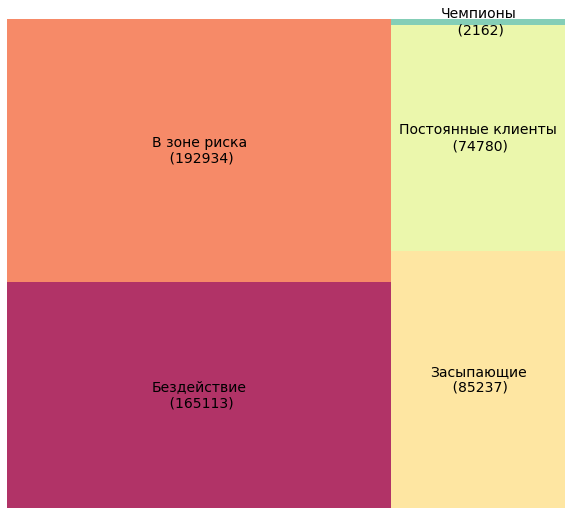

In [122]:
import squarify 

data = RFM.groupby('Segment').size().reset_index(name='Counts')
labels = data.apply(lambda s: str(s[0]) + "\n (" + str(s[1]) + ")", axis=1)
size = data['Counts'].values.tolist()
color = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Plot
plt.figure(figsize=(10,9))
squarify.plot(sizes=size, label=labels, color=color, alpha=0.8, text_kwargs={'fontsize':14})

# Decorate
#plt.title('Древовидная карта сегментации клиентов', fontsize = 15)
plt.axis('off')
plt.show()

In [11]:
RFM.to_csv('clients_RFM.csv',sep=';',index=False, header=True)
clients_RFM = pd.read_csv('./clients_RFM.csv', sep = ';')

In [12]:
#создание таблицы с сегментами в БД
connection, cursor = db.connect_db()
cursor.execute('''
DROP TABLE IF EXISTS clients_RFM;

CREATE TABLE clients_RFM(
    customer_id VARCHAR,
    recency INT,
    frequency INT,
    monetary REAL,
    RecencyCluster INT,
    FrequencyCluster INT,
    MonetaryCluster INT,
    OverallScore INT,
    Segment VARCHAR
)
''')

with open('./clients_RFM.csv') as clients_RFM:
    for line in clients_RFM:
        cursor.copy_from(clients_RFM, 'clients_RFM', 
            columns=(
                'customer_id',
                'recency' ,
                'frequency',
                'monetary',
                'RecencyCluster' ,
                'FrequencyCluster' ,
                'MonetaryCluster' ,
                'OverallScore' ,
                'Segment'), sep=";", null='NULL')
db.close_connection(connection, cursor)

Database opened successfully


## ПРОВЕРКА ПРЕДЛОЖЕННЫХ ПРОМО И СЕГМЕНТОВ КЛИЕНТОВ

### Кампания MBA

In [9]:
connection, cursor = db.connect_db()
cursor.execute('''
SELECT
    t1.campaign_type,
    t1.customer_id,
    t1.discount_type1,
    t1.promo_id,
    t1.msg_text,
    t1.Segment,
    CASE
        WHEN
            billspromo.check_id LIKE '%'
        THEN
            1
        ELSE
            0
        END con
FROM
    (SELECT
        pers_offer.campaign_type,
        pers_offer.offer_start_dt,
        pers_offer.offer_end_dt,
        pers_offer.customer_id,
        pers_offer.discount_type1,
        pers_offer.promo_id,
        pers_offer.msg_text,
        clients_RFM.Segment

    FROM pers_offer LEFT JOIN (SELECT
                                    clients_RFM.customer_id,
                                    clients_RFM.Segment
                                FROM clients_RFM) clients_RFM
                                ON pers_offer.customer_id = 
                                   clients_RFM.customer_id
    ) t1 LEFT JOIN (SELECT
                        billspromo.check_id,
                        billspromo.check_date,
                        billspromo.customer_id,
                        billspromo.promo_id
                    FROM
                        billspromo
                    GROUP BY 1,2,3,4) billspromo
                    ON (billspromo.promo_id = t1.promo_id 
                    AND billspromo.customer_id = t1.customer_id 
                    AND billspromo.check_date BETWEEN t1.offer_start_dt 
                    AND t1.offer_end_dt)
WHERE t1.campaign_type = 'MBA'

''')
result = cursor.fetchall()
db.close_connection(connection, cursor)
promo_segments_MBA = pd.DataFrame(result, columns = ['campaign_type',
                                                     'customer_id',
                                                     'discount_type1',
                                                     'promo_id',
                                                     'msg_text',
                                                     'Segment',
                                                     'conversion'])

Database opened successfully


In [14]:
#столько клиентов никак не сегментированы, так как у них не было покупок за последние пол года
print('Не сегментировано:', promo_segments_MBA['Segment'].isna().sum())
# заменяем пропуски на сегмент "Ушедшие", так как эти люди не покупали ничего последние пол года
#(их нет в таблице bills)
promo_segments_MBA.loc[promo_segments_MBA['Segment'].isna(), 'Segment'] = 'Ушедшие'

Не сегментировано: 7


In [130]:
pd.concat([promo_segments_MBA.groupby('Segment')['conversion'].mean()*100, promo_segments_MBA.groupby('Segment').size()], axis=1).rename(columns = {0:'count'})

,conversion,count
Segment,,
Бездействие,0.864362,1504
В зоне риска,1.416431,3177
Засыпающие,1.112100,2248
Постоянные клиенты,2.979684,2215
Ушедшие,0.000000,7
Чемпионы,3.278689,61


In [123]:
promo_segments_MBA.groupby('Segment')['conversion'].mean()

Segment
Бездействие           0.008644
В зоне риска          0.014164
Засыпающие            0.011121
Постоянные клиенты    0.029797
Ушедшие               0.000000
Чемпионы              0.032787
Name: conversion, dtype: float64

In [124]:
promo_segments_MBA.groupby('Segment').size()

Segment
Бездействие           1504
В зоне риска          3177
Засыпающие            2248
Постоянные клиенты    2215
Ушедшие                  7
Чемпионы                61
dtype: int64

In [63]:
# •	MBA – кампания, направленная на расширение потребительской корзины, и как видно из таблицы,
#она наиболее эффективна для постоянных клиентов и чемпионов
# а от сообщений, отправленых ушедшим клиентам, которые вообще не активны как минимум пол года, конверсия =  0

### CHURN сегментация 

In [131]:
connection, cursor = db.connect_db()
cursor.execute('''
SELECT
    t1.campaign_type,
    t1.customer_id,
    t1.discount_type1,
    t1.promo_id,
    t1.msg_text,
    t1.Segment,
    CASE
        WHEN
            billspromo.check_id LIKE '%'
        THEN
            1
        ELSE
            0
        END con
FROM
    (SELECT
        pers_offer.campaign_type,
        pers_offer.offer_start_dt,
        pers_offer.offer_end_dt,
        pers_offer.customer_id,
        pers_offer.discount_type1,
        pers_offer.promo_id,
        pers_offer.msg_text,
        clients_RFM.Segment

    FROM pers_offer LEFT JOIN (SELECT
                                    clients_RFM.customer_id,
                                    clients_RFM.Segment
                                FROM clients_RFM) clients_RFM
                                ON pers_offer.customer_id = clients_RFM.customer_id
    ) t1 LEFT JOIN (SELECT
                        billspromo.check_id,
                        billspromo.check_date,
                        billspromo.customer_id,
                        billspromo.promo_id
                    FROM
                        billspromo
                    GROUP BY 1,2,3,4) billspromo
                    ON (billspromo.promo_id = t1.promo_id 
                    AND billspromo.customer_id = t1.customer_id 
                    AND billspromo.check_date BETWEEN t1.offer_start_dt AND t1.offer_end_dt)
WHERE t1.campaign_type = 'Churn'

''')
result = cursor.fetchall()
db.close_connection(connection, cursor)
promo_segments_CHURN = pd.DataFrame(result, columns = ['campaign_type',
                                                     'customer_id',
                                                     'discount_type1',
                                                     'promo_id',
                                                     'msg_text',
                                                     'Segment',
                                                     'conversion'])

Database opened successfully


In [132]:
#столько клиентов никак не сегментированы, так как у них не было покупок за последние пол года
print('Не сегментировано:', promo_segments_CHURN['Segment'].isna().sum())
# заменяем пропуски на сегмент "Ушедшие", так как эти люди не покупали ничего последние пол года
#(их нет в таблице bills)
promo_segments_CHURN.loc[promo_segments_CHURN['Segment'].isna(), 'Segment'] = 'Ушедшие'

Не сегментировано: 724


In [134]:
pd.concat([promo_segments_CHURN.groupby('Segment')['conversion'].mean()*100, promo_segments_CHURN.groupby('Segment').size()], axis=1).rename(columns = {0:'count'})

,conversion,count
Segment,,
Бездействие,1.710093,127303
В зоне риска,3.821124,177016
Засыпающие,5.498295,75678
Постоянные клиенты,7.460832,41041
Ушедшие,0.414365,724
Чемпионы,10.873786,515


In [19]:
promo_segments_CHURN.groupby('Segment')['conversion'].mean()

Segment
Бездействие           0.017101
В зоне риска          0.038211
Засыпающие            0.054983
Постоянные клиенты    0.074608
Ушедшие               0.004144
Чемпионы              0.108738
Name: conversion, dtype: float64

In [20]:
promo_segments_CHURN.groupby('Segment').size()

Segment
Бездействие           127303
В зоне риска          177016
Засыпающие             75678
Постоянные клиенты     41041
Ушедшие                  724
Чемпионы                 515
dtype: int64

In [21]:
# CHURN – кампания, направленная на клиентов отточников
# 515 сообщения были отправлены чемпионам, которые явно отточниками не являются
# а также 41041 сообщений отправленны постоянным клиентам

### PTB сегментация

In [22]:
connection, cursor = db.connect_db()
cursor.execute('''
SELECT
    t1.campaign_type,
    t1.customer_id,
    t1.discount_type1,
    t1.promo_id,
    t1.msg_text,
    t1.Segment,
    CASE
        WHEN
            billspromo.check_id LIKE '%'
        THEN
            1
        ELSE
            0
        END con
FROM
    (SELECT
        pers_offer.campaign_type,
        pers_offer.offer_start_dt,
        pers_offer.offer_end_dt,
        pers_offer.customer_id,
        pers_offer.discount_type1,
        pers_offer.promo_id,
        pers_offer.msg_text,
        clients_RFM.Segment

    FROM pers_offer LEFT JOIN (SELECT
                                    clients_RFM.customer_id,
                                    clients_RFM.Segment
                                FROM clients_RFM) clients_RFM
                                ON pers_offer.customer_id = clients_RFM.customer_id
    ) t1 LEFT JOIN (SELECT
                        billspromo.check_id,
                        billspromo.check_date,
                        billspromo.customer_id,
                        billspromo.promo_id
                    FROM
                        billspromo
                    GROUP BY 1,2,3,4) billspromo
                    ON (billspromo.promo_id = t1.promo_id 
                    AND billspromo.customer_id = t1.customer_id 
                    AND billspromo.check_date BETWEEN t1.offer_start_dt AND t1.offer_end_dt)
WHERE t1.campaign_type = 'PTB'

''')
result = cursor.fetchall()
db.close_connection(connection, cursor)
promo_segments_PTB = pd.DataFrame(result, columns = ['campaign_type',
                                                     'customer_id',
                                                     'discount_type1',
                                                     'promo_id',
                                                     'msg_text',
                                                     'Segment',
                                                     'conversion'])

Database opened successfully


In [23]:
#столько клиентов никак не сегментированы, так как у них не было покупок за последние пол года
print('Не сегментировано:', promo_segments_PTB['Segment'].isna().sum())
# заменяем пропуски на сегмент "Ушедшие", так как эти люди не покупали ничего последние пол года
#(их нет в таблице bills)
promo_segments_PTB.loc[promo_segments_PTB['Segment'].isna(), 'Segment'] = 'Ушедшие'

Не сегментировано: 137


In [137]:
pd.concat([promo_segments_PTB.groupby('Segment')['conversion'].mean()*100, promo_segments_PTB.groupby('Segment').size()], axis=1).rename(columns = {0:'count'})

,conversion,count
Segment,,
Бездействие,1.828225,71873
В зоне риска,4.842280,214114
Засыпающие,7.115523,176909
Постоянные клиенты,8.987985,203327
Ушедшие,0.000000,137
Чемпионы,12.026862,6552


In [24]:
promo_segments_PTB.groupby('Segment')['conversion'].mean()

Segment
Бездействие           0.018282
В зоне риска          0.048423
Засыпающие            0.071155
Постоянные клиенты    0.089880
Ушедшие               0.000000
Чемпионы              0.120269
Name: conversion, dtype: float64

In [25]:
promo_segments_PTB.groupby('Segment').size()

Segment
Бездействие            71873
В зоне риска          214114
Засыпающие            176909
Постоянные клиенты    203327
Ушедшие                  137
Чемпионы                6552
dtype: int64

In [ ]:
#Кампания РТВ направленна на предложение товара, который клиент наиболее склонен купить
# для ушедших клиентов из 137 отправленных сообщений ни одно предложение не сконветировалось
# возможно имеет смысл перенести эту группу клиентов в кампанию CHURN

# Влияние времени отправки сообщения на конверсию

In [29]:
connection, cursor = db.connect_db()
cursor.execute('''
SELECT
    t1.customer_id,
    t1.CAMPAIGN_TYPE,
    t1.discount_type1,
    t1.discount_amt,
    t1.d,
    t1.h,
    t1.min,
    t1.msg_text,
    t1.con,
    t2.segment
FROM 
    (SELECT 
        pers_offer.customer_id,
        pers_offer.CAMPAIGN_TYPE,
        pers_offer.discount_type1,
        pers_offer.discount_amt,
        EXTRACT(DOW FROM(pers_offer.RESPONSE_DTTM)) d,
        EXTRACT(HOUR FROM(pers_offer.RESPONSE_DTTM)) h,
        EXTRACT(MINUTE FROM(pers_offer.RESPONSE_DTTM)) min,
        substring(msg_text, '^[\w"%]*\s[\w!%-]*\s[^\wскидка|^\wСКИДКА]*') msg_text,
        CASE
            WHEN
                billspromo.check_id LIKE '%'
            THEN
                1
            ELSE
                0
            END con
    FROM pers_offer LEFT JOIN (SELECT
                                billspromo.check_id,
                                billspromo.check_date,
                                billspromo.customer_id,
                                billspromo.promo_id
                            FROM
                                billspromo
                            GROUP BY 1,2,3,4) billspromo
                            ON (billspromo.promo_id = pers_offer.promo_id 
                            AND billspromo.customer_id = pers_offer.customer_id 
                            AND billspromo.check_date BETWEEN pers_offer.offer_start_dt 
                                                          AND pers_offer.offer_end_dt)
    ) t1 LEFT JOIN (SELECT
                        clients_RFM.customer_id,
                        clients_RFM.Segment
                    FROM
                       clients_RFM ) t2
                    ON (t2.customer_id = t1.customer_id)

GROUP BY 1,2,3,4,5,6,7,8,9,10    
''')
result = cursor.fetchall()
db.close_connection(connection, cursor)
timest = pd.DataFrame(result, columns = ['customer_id',
                                         'CAMPAIGN_TYPE',
                                         'discount_type1',
                                         'discount_amt',
                                         'dow',
                                         'hour',
                                         'minute',
                                        'msg_text',
                                        'conversion',
                                        'segment'])

Database opened successfully


In [30]:
timest.groupby('msg_text').size().sum()

1129448

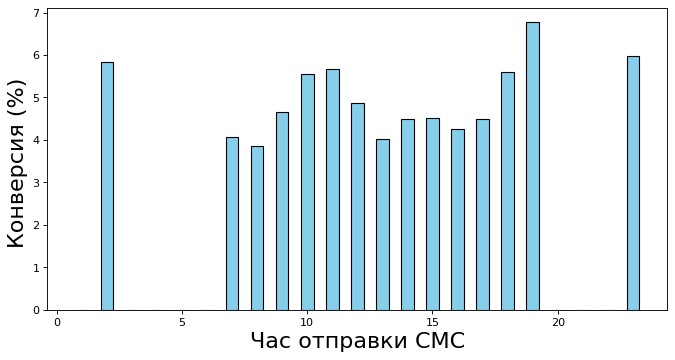

In [207]:
df = (timest.groupby('hour').mean()['conversion']*100).reset_index(name='conversion')
text = df['hour']
plt.figure(figsize=(10, 5), dpi= 80)
plt.bar(text, df['conversion'],width=.5 , color = 'skyblue', edgecolor='black')
plt.ylabel('Конверсия (%) ', fontsize=20)
plt.xlabel('Час отправки СМС', fontsize=20)
plt.show()

In [138]:
# конверсия в % от часа отправки сообщения
pd.concat([timest.groupby('hour')['conversion'].mean()*100, timest.groupby('hour').size()], axis=1).rename(columns = {0:'count'})

,conversion,count
hour,,
1.0,0.000000,1
2.0,5.824583,16190
3.0,0.000000,7
4.0,0.000000,3
5.0,0.000000,7
6.0,0.000000,3
7.0,4.077432,71908
8.0,3.845814,203650
9.0,4.667927,98352


In [ ]:
# сообщения,в 2,3,4,5,6,20,21,22 часа - без конверсии
#но для адекватной оценки конверсии, не достаточно количества отправленых сообщений в это время 

## Размер и тип скидки скидки

In [227]:
timest.groupby('discount_type1')['conversion'].mean()*100

discount_type1
1    4.258160
2    4.876858
Name: conversion, dtype: float64

In [228]:
timest.groupby('discount_amt')['conversion'].mean()*100

discount_amt
15.0    7.248046
20.0    4.151130
25.0    3.986539
30.0    3.492998
35.0    5.520241
40.0    6.787931
50.0    0.000000
Name: conversion, dtype: float64

In [231]:
timest.groupby(['discount_amt', 'discount_type1' ])['conversion'].mean()*100

discount_amt  discount_type1
15.0          2                 7.248046
20.0          2                 4.151130
25.0          1                 0.808898
              2                 3.994261
30.0          1                 2.727273
              2                 3.499177
35.0          1                 0.000000
              2                 5.520521
40.0          2                 6.787931
50.0          2                 0.000000
Name: conversion, dtype: float64

#     -----------------------------------------------------------------------------

## Текст сообщения

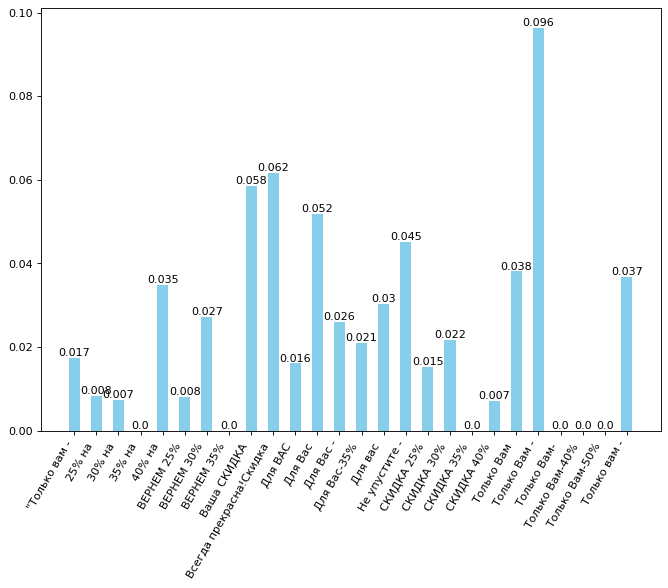

In [149]:
df2 = timest.groupby('msg_text').mean()['conversion'].reset_index(name='conversion')
text = df2['msg_text']
plt.figure(figsize=(10, 7), dpi= 80)
plt.bar(text, df2['conversion'],width=.5, color = 'skyblue' )
for i, val in enumerate(df2['conversion'].values):
    plt.text(i, val, round(float(val), 3), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':10})
plt.gca().set_xticklabels(text, rotation=60, horizontalalignment= 'right')
plt.show()

## ANOVA

In [42]:
# ANOVA для всех видов сообщений, сгруппированных по размеру скидки
for i in timest['discount_amt'].unique()[1:-1]:
    print(i)
    mess = timest['msg_text'].loc[timest['discount_amt'] ==i].unique()[1:]
    print(stats.f_oneway(*(timest[timest['msg_text'] == x]['conversion'] for x in mess)))

30.0
F_onewayResult(statistic=462.8199362273486, pvalue=0.0)
15.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:3339: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / len(a)


F_onewayResult(statistic=nan, pvalue=nan)
40.0
F_onewayResult(statistic=688.7597534920415, pvalue=0.0)
20.0
F_onewayResult(statistic=989.5175435427983, pvalue=5.467949585696333e-217)
25.0
F_onewayResult(statistic=98.5156419382654, pvalue=2.3256733030170898e-124)
35.0
F_onewayResult(statistic=9.271282759492237, pvalue=1.7361551728757193e-07)


In [43]:
days_of_week = timest['dow'].unique()
stats.f_oneway(*(timest[timest['dow'] == i]['conversion'] for i in days_of_week))

F_onewayResult(statistic=177.32779385716208, pvalue=1.624519328558481e-226)

In [45]:
hours = timest['hour'].unique()
stats.f_oneway(*(timest[timest['hour'] == i]['conversion'] for i in hours))

F_onewayResult(statistic=62.15220905187376, pvalue=1.0811062897815982e-275)

In [46]:
discount = timest['discount_amt'].unique()[1:]
stats.f_oneway(*(timest[timest['discount_amt'] == i]['conversion'] for i in discount))

F_onewayResult(statistic=807.0203922597028, pvalue=0.0)

In [ ]:
#Тест ANOVA показал, что существуют значимые различия средних и по видам текста в сообщениях,
#и по дням недели, и по часам отправки сообщений

In [ ]:
#Далее будет проведен Anova для сгруппированных видов текста, вроде "Только вам и Только Вам" и т.д.

## Возраст клиентов

In [48]:
clients = pd.read_csv('./data/clients.csv', sep = ';')

In [52]:
clients['age'].unique()

array([ 68.,  32.,  61.,  60.,  79.,  40.,  27.,  34.,  36.,  45.,  22.,
        38.,  76.,  42.,  69.,  35.,  52.,  26.,  59.,  75.,  56.,  29.,
        51.,  54.,  43.,  49.,  18.,  33.,  57.,  24.,  37.,  19.,  30.,
        48.,  55.,  41.,  78.,  65.,  20.,  64.,  25.,  89.,  39.,  58.,
        31.,  63.,  46.,  nan,  28.,  66.,  72.,  44.,  14.,  23.,  21.,
        17.,  74.,  53.,  47.,  16.,  73.,  80.,  67.,  13.,  50.,  70.,
        62.,  82.,  83.,  71.,  81.,  84.,  77.,  15., -70.,   1.,  11.,
       120.,   0.,  12.,  85.,   9., 119.,   5.,   6., 114.,  92.,  91.,
       117.,  87.,  86.,  88.,  90., 118.,  10.,   3.,  -5.,  95., 115.,
        98.,  93.,   8.,   2., 109., 104., -68.,   7.,   4., 113., -60.,
       106., 110.,  -2., 100.,  94., 101.,  -1., 111., 116., -63., -25.,
       112., -71.,  99.,  97., -10., 107.])

In [59]:
# у этих клиентов отрицательный возраст
clients.loc[clients['age'] <0 ]['age']

1122     -70.0
89053     -5.0
136154   -68.0
206627   -60.0
218752    -2.0
238305    -1.0
290341   -63.0
312597   -25.0
329585   -71.0
438098   -10.0
457546    -1.0
Name: age, dtype: float64

In [57]:
# у 224 клиентов возраст больше 100 лет
clients.loc[clients['age'] >100 ]['age'].shape

(244,)

In [ ]:
# у 887 клиентов возраст меньше 14 лет
clients.loc[clients['age'] < 14 ]['age'].shape

In [ ]:
#причины отрицательного возраста:
#возможно сбой при выгрузке?
#верхняя граница года рождения указана неправильно в системе? (поэтому и клиенты с возрастом 2 года и т.д. )


### ТОВАРНЫЕ ГРУППЫ

### FULL (Товарные группы)

In [19]:
connection, cursor = db.connect_db()
cursor.execute('''
SELECT
    t1.campaign_type,
    t1.customer_id,
    t1.discount_type1,
    t1.discount_amt,
    t1.promo_id,
    t1.msg_text,
    t1.item2,
    products.product_direction_name,
    products.category_name,    
    t1.con
FROM
    (SELECT
        pers_offer.campaign_type,
        pers_offer.offer_start_dt,
        pers_offer.offer_end_dt,
        pers_offer.customer_id,
        pers_offer.discount_type1,
        pers_offer.discount_amt,
        pers_offer.promo_id,
        pers_offer.msg_text,
        substring(pers_offer.item2, '^\w\d+') item2,
        CASE
            WHEN
                billspromo.check_id LIKE '%'
            THEN
                1
            ELSE
                0
            END con

    FROM pers_offer LEFT JOIN (SELECT
                        billspromo.check_id,
                        billspromo.check_date,
                        billspromo.customer_id,
                        billspromo.promo_id
                    FROM
                        billspromo
                    GROUP BY 1,2,3,4) billspromo
                    ON (billspromo.promo_id = pers_offer.promo_id 
                    AND billspromo.customer_id = pers_offer.customer_id 
                    AND billspromo.check_date BETWEEN pers_offer.offer_start_dt 
                    AND pers_offer.offer_end_dt)
        WHERE pers_offer.campaign_type = 'PTB' 
        OR pers_offer.campaign_type = 'MBA' 
        OR pers_offer.campaign_type = 'Churn'
        GROUP BY 1,2,3,4,5,6,7,8,9,10
) t1 INNER JOIN (SELECT
                    products.category_cd,
                    products.group_cd,
                    products.subgroup_cd,
                    products.product_direction_name,
                    products.category_name
                FROM products) products
                ON (t1.item2 = products.category_cd OR
                    t1.item2 = products.group_cd OR
                    t1.item2 = products.subgroup_cd)
GROUP BY 1,2,3,4,5,6,7,8,9,10
''')
result = cursor.fetchall()
db.close_connection(connection, cursor)
pers_full = pd.DataFrame(result, columns = ['campaign_type',
                                            'customer_id',
                                            'discount_type1',
                                            'discount_amt',
                                            'promo_id',
                                            'msg_text',
                                            'item2',
                                            'product_direction_name',
                                            'category_name',
                                            'conversion'])

Database opened successfully


In [22]:
pers_full.to_csv('pers_full.csv',sep=';',index=True, header=True)

In [23]:
pers_full

,campaign_type,customer_id,discount_type1,discount_amt,promo_id,msg_text,item2,product_direction_name,category_name,conversion
0,Churn,00003187-2797-47f5-9ff1-5c2a3770c03c-ws,2,30.0,681593,Только вам -30% на бальзамы для волос до 6.03!...,S10534,КРАСОТА,[уход за волосами]для волос,0
1,Churn,0000431c-4744-4c82-bdca-0859de61566c-ws,2,30.0,681593,Только вам -30% на бальзамы для волос до 26.11...,S10534,КРАСОТА,[уход за волосами]для волос,0
2,Churn,0000e13f-2e0e-43d4-88da-545e1685eff9-ws,2,25.0,681593,Только вам -25% на зубные щетки до 6.03! Улыбк...,G1213,ЧИСТОТА,[уход за полостью рта],0
3,Churn,0000e13f-2e0e-43d4-88da-545e1685eff9-ws,2,35.0,681593,Только вам -35% на средства для ногтей до 21.0...,G1062,ДЕКОР,[декоративная косметика],0
4,Churn,00016299-c3d4-44aa-85b9-2903e3e577bf-ws,2,25.0,681593,Только вам -25% на косметику для ресниц до 25....,G1063,ДЕКОР,[декоративная косметика],0
...,...,...,...,...,...,...,...,...,...,...
1084148,PTB,ffff5bc2-927e-4426-aae4-2eacbb66b99e-ws,2,30.0,681593,Для Вас скидка 30% на шампуни для волос по 2.1...,S11647,КРАСОТА,[уход за волосами]для волос,0
1084149,PTB,ffff5bc2-927e-4426-aae4-2eacbb66b99e-ws,2,40.0,681593,Для Вас 40% на прокладки по 26.01 (кроме товар...,G1177,ЧИСТОТА,[средство гигиены],0
1084150,PTB,ffffafff-3029-4e7b-a5a1-a92adf226eb2-ws,2,25.0,681593,Для Вас 25% на краски для волос по 14.11. Кром...,C020,КРАСОТА,для окраски волос,0
1084151,PTB,ffffc42c-ce8c-4fd9-b605-fe997bdc3707-ws,2,40.0,681593,"Ваша СКИДКА 40% на декор. косметику по 12.02,к...",C016,ДЕКОР,[декоративная косметика],0


In [51]:
pers_full.groupby(['category_name', 'discount_amt'])['conversion'].mean()*100

category_name                discount_amt
[бритье]                     20.0             3.448022
[декоративная косметика]     15.0             5.408207
                             20.0             5.166300
                             25.0             2.706562
                             30.0             2.551585
                             35.0             1.894626
                             40.0             6.467002
[депиляция]                  30.0             1.247401
[для стирки и белья]         25.0             0.000000
                             30.0             0.000000
                             35.0             3.795946
                             40.0             4.890589
[колготки]                   25.0             2.866163
[парфюмерия массмаркет]      30.0             3.508772
[средство гигиены]           30.0             5.990410
                             40.0             8.804846
[товары для душа и ванны]    25.0             1.517031
                       

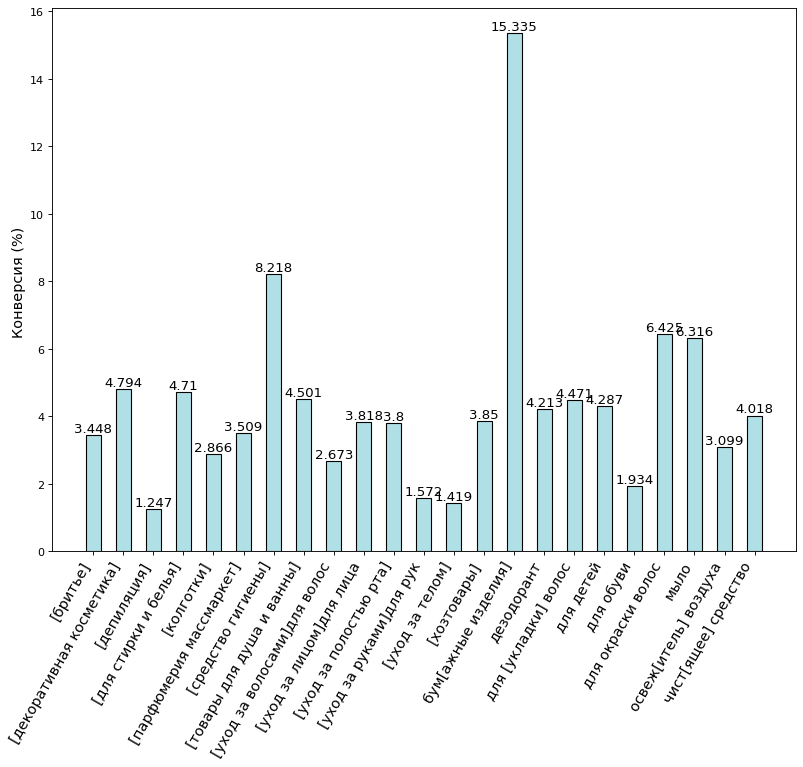

In [50]:
df = (pers_full.groupby('category_name')['conversion'].mean()*100).reset_index(name='conversion')
text = df['category_name']
plt.figure(figsize=(12, 9), dpi= 80)
plt.bar(text, df['conversion'],width=.5, color = 'powderblue', edgecolor='black' )
for i, value in enumerate(df2['conversion'].values):
    plt.text(i, value, round(float(value), 3), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.gca().set_xticklabels(text, rotation=60, horizontalalignment= 'right',fontdict={'fontweight':500, 'size':13} )
plt.ylabel('Конверсия (%) ', fontsize=13)
plt.show()

## С текстом сообщения

In [52]:
connection, cursor = db.connect_db()
cursor.execute('''
SELECT
    t1.campaign_type,
    t1.customer_id,
    t1.discount_type1,
    t1.discount_amt,
    t1.promo_id,
    t1.msg_text,
    t1.item2,
    products.product_direction_name,
    products.category_name,    
    t1.con
FROM
    (SELECT
        pers_offer.campaign_type,
        pers_offer.offer_start_dt,
        pers_offer.offer_end_dt,
        pers_offer.customer_id,
        pers_offer.discount_type1,
        pers_offer.discount_amt,
        pers_offer.promo_id,
        substring(msg_text, '^[\w"%]*\s[\w!%-]*\s[^\wскидка|^\wСКИДКА]*') msg_text,
        substring(pers_offer.item2, '^\w\d+') item2,
        CASE
            WHEN
                billspromo.check_id LIKE '%'
            THEN
                1
            ELSE
                0
            END con

    FROM pers_offer LEFT JOIN (SELECT
                        billspromo.check_id,
                        billspromo.check_date,
                        billspromo.customer_id,
                        billspromo.promo_id
                    FROM
                        billspromo
                    GROUP BY 1,2,3,4) billspromo
                    ON (billspromo.promo_id = pers_offer.promo_id 
                    AND billspromo.customer_id = pers_offer.customer_id 
                    AND billspromo.check_date BETWEEN pers_offer.offer_start_dt 
                    AND pers_offer.offer_end_dt)
        WHERE pers_offer.campaign_type = 'PTB' 
        OR pers_offer.campaign_type = 'MBA' 
        OR pers_offer.campaign_type = 'Churn'
        GROUP BY 1,2,3,4,5,6,7,8,9,10
) t1 INNER JOIN (SELECT
                    products.category_cd,
                    products.group_cd,
                    products.subgroup_cd,
                    products.product_direction_name,
                    products.category_name
                FROM products) products
                ON (t1.item2 = products.category_cd OR
                    t1.item2 = products.group_cd OR
                    t1.item2 = products.subgroup_cd)
GROUP BY 1,2,3,4,5,6,7,8,9,10
''')
result = cursor.fetchall()
db.close_connection(connection, cursor)
pers_full2 = pd.DataFrame(result, columns = ['campaign_type',
                                            'customer_id',
                                            'discount_type1',
                                            'discount_amt',
                                            'promo_id',
                                            'msg_text',
                                            'item2',
                                            'product_direction_name',
                                            'category_name',
                                            'conversion'])

Database opened successfully


In [54]:
pers_full2.to_csv('pers_full2.csv',sep=';',index=True, header=True)

In [15]:
pers_full2 = pd.read_csv('./pers_full2.csv',sep=';')

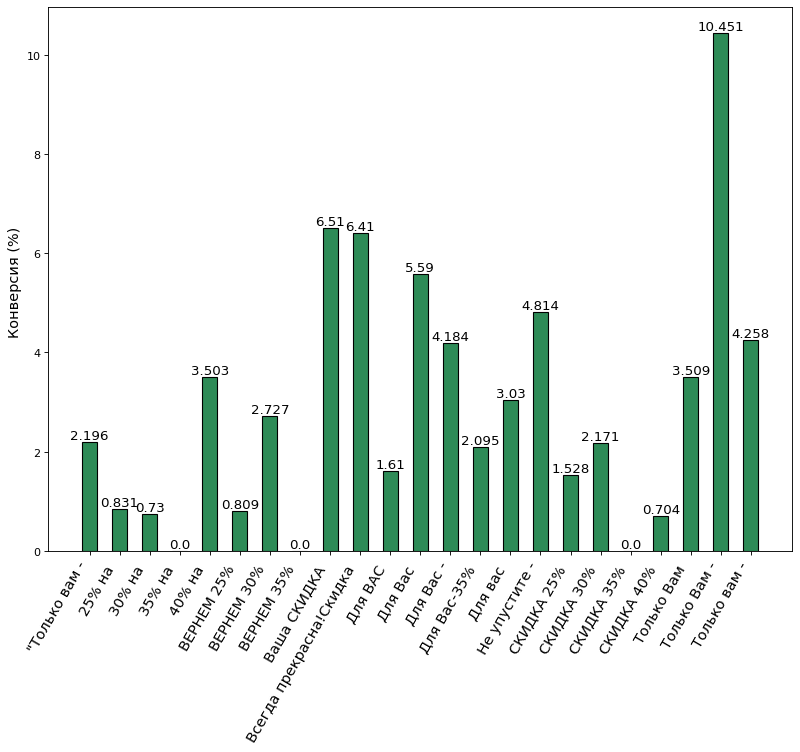

In [22]:
df = (pers_full2.groupby('msg_text').mean()['conversion']*100).reset_index(name='conversion')
text = df['msg_text']
plt.figure(figsize=(12, 9), dpi= 80)
plt.bar(text, df['conversion'],width=.5, color = 'seagreen', edgecolor='black' )
for i, value in enumerate(df2['conversion'].values):
    plt.text(i, value, round(float(value), 3), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.gca().set_xticklabels(text, rotation=60, horizontalalignment= 'right',fontdict={'fontweight':500, 'size':13} )
plt.ylabel('Конверсия (%) ', fontsize=13)
plt.show()

In [57]:
pers_full2.groupby(['product_direction_name', 'discount_amt', 'msg_text',])['conversion'].mean()*100

product_direction_name  discount_amt  msg_text                
ДЕКОР                   15.0          Для Вас                      5.408207
                        20.0          Для Вас                      5.248078
                        25.0          Только вам -                 3.492320
                        30.0          Только Вам                   3.508772
                                      Только вам -                 3.304821
                        35.0          Только вам -                 2.480761
                        40.0          Ваша СКИДКА                  7.210211
КРАСОТА                 20.0          Ваша СКИДКА                  3.764822
                                      Для Вас                      4.499408
                                      Только вам -                 3.480142
                        25.0          "Только вам -                2.196053
                                      25% на                       0.573066
                         

# ВЛИЯНИЕ ПЕРИОДА АКЦИИ

In [60]:
connection, cursor = db.connect_db()
cursor.execute('''
SELECT
    t1.customer_id,
    t1.CAMPAIGN_TYPE,
    t1.discount_type1,
    t1.discount_amt,
    t1.period,
    t1.msg_text,
    t1.con,
    t2.segment
FROM 
    (SELECT 
        pers_offer.customer_id,
        pers_offer.CAMPAIGN_TYPE,
        pers_offer.discount_type1,
        pers_offer.discount_amt,
        (pers_offer.offer_end_dt - pers_offer.offer_start_dt) period,
        substring(msg_text, '^[\w"%]*\s[\w!%-]*\s[^\wскидка|^\wСКИДКА]*') msg_text,
        CASE
            WHEN
                billspromo.check_id LIKE '%'
            THEN
                1
            ELSE
                0
            END con
    FROM pers_offer LEFT JOIN (SELECT
                                billspromo.check_id,
                                billspromo.check_date,
                                billspromo.customer_id,
                                billspromo.promo_id
                            FROM
                                billspromo
                            GROUP BY 1,2,3,4) billspromo
                            ON (billspromo.promo_id = pers_offer.promo_id 
                            AND billspromo.customer_id = pers_offer.customer_id 
                            AND billspromo.check_date BETWEEN pers_offer.offer_start_dt 
                                                          AND pers_offer.offer_end_dt)
    ) t1 LEFT JOIN (SELECT
                        clients_RFM.customer_id,
                        clients_RFM.Segment
                    FROM
                       clients_RFM ) t2
                    ON (t2.customer_id = t1.customer_id)

GROUP BY 1,2,3,4,5,6,7,8
''')
result = cursor.fetchall()
db.close_connection(connection, cursor)
period = pd.DataFrame(result, columns = ['customer_id',
                                         'CAMPAIGN_TYPE',
                                         'discount_type1',
                                         'discount_amt',
                                         'period',
                                        'msg_text',
                                        'conversion',
                                        'segment'])

Database opened successfully


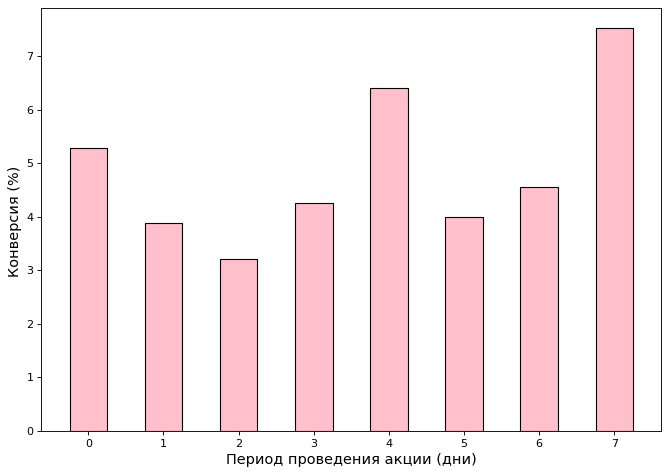

In [76]:
df = (period.groupby('period').mean()['conversion']*100).reset_index(name='conversion')
text = df['period']
plt.figure(figsize=(10, 7), dpi= 80)
plt.bar(text, df2['conversion'],width=.5, color = 'pink', edgecolor='black' )
plt.ylabel('Конверсия (%) ', fontsize=13)
plt.xlabel('Период проведения акции (дни)', fontsize=13)
plt.show()

In [77]:
per = period['period'].unique()
stats.f_oneway(*(period[period['period'] == i]['conversion'] for i in per))

F_onewayResult(statistic=412.11156680905907, pvalue=0.0)

## Добавление фильтров для клиентов

In [ ]:
connection, cursor = db.connect_db()
cursor.execute('''
SELECT
    check_id,
    check_date,
    customer_id, 
    EXTRACT (DOW FROM check_date) check_dow
FROM bills
GROUP BY 1,2,3,4
''')
result = cursor.fetchall()
db.close_connection(connection, cursor)
clients_days = pd.DataFrame(result, columns = ['check_id',
                                               'check_date',
                                               'customer_id',
                                               'check_dow'])

In [82]:
connection, cursor = db.connect_db()
cursor.execute('''
SELECT
    customer_id,
    recency,
    frequency,
    monetary,
    RecencyCluster,
    FrequencyCluster,
    MonetaryCluster,
    OverallScore,
    Segment
FROM clients_RFM
''')
result = cursor.fetchall()
db.close_connection(connection, cursor)
clients_RFM = pd.DataFrame(result, columns=['customer_id',
                                            'recency' ,
                                            'frequency',
                                            'monetary',
                                            'RecencyCluster' ,
                                            'FrequencyCluster' ,
                                            'MonetaryCluster' ,
                                            'OverallScore' ,
                                            'Segment'])

Database opened successfully


In [85]:
clients_RFM = pd.merge(left = clients_RFM.set_index('customer_id'), right = clients_days[['customer_id', 'check_dow']].groupby('customer_id').agg(pd.Series.mode), how = 'left', left_index = True, right_index = True).reset_index()
clients_RFM.rename(columns=lambda x: x.replace('check_dow', 'most_common_dow'), inplace=True)

In [125]:
clients_RFM['holiday_weekday'] = None
# 1 - клиент выходного дня
# 2  - клиент буднего дня
for n, i in enumerate(clients_RFM['most_common_dow']):
    if isinstance(i,np.ndarray):
        holiday = list()
        weekday = list()
        for j in i:
            if j ==0 or j == 6:
                holiday.append(j)
            else:
                weekday.append(j)
        if len(holiday) > len(weekday):
            clients_RFM['holiday_weekday'][n]= 'ВЫХОДНОЙ'
        else:
            clients_RFM['holiday_weekday'][n]= 'БУДНИЙ'
    else:
        if i == 0 or i ==6:
            clients_RFM['holiday_weekday'][n]= 'ВЫХОДНОЙ'
        else:
            clients_RFM['holiday_weekday'][n]= 'БУДНИЙ'



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [173]:
connection, cursor = db.connect_db()
cursor.execute('''ALTER TABLE clients_RFM DROP COLUMN holiday_weekday  ;
ALTER TABLE clients_RFM ADD COLUMN most_common_dow VARCHAR;
ALTER TABLE clients_RFM ADD COLUMN holiday_weekday VARCHAR ''')

db.close_connection(connection, cursor)

Database opened successfully


In [164]:
clients_RFM.rename(columns = {'holiday/weekday':'holiday_weekday'}, inplace = True)

In [166]:
clients_RFM.to_csv('./data/clients_RFM.csv',sep=';',index=False, header=True)

In [179]:
clients_RFM = pd.read_csv('./data/clients_RFM.csv',sep=';')

In [176]:
#перезапись таблицы clients_RFM с добавлением информации о дне недели в БД
connection, cursor = db.connect_db()
cursor.execute('''
DROP TABLE IF EXISTS clients_RFM;

CREATE TABLE clients_RFM(
	customer_id VARCHAR,
	recency INT,
	frequency INT,
	monetary REAL,
	RecencyCluster INT,
	FrequencyCluster INT,
	MonetaryCluster INT,
	OverallScore INT,
	Segment VARCHAR,
    most_common_dow VARCHAR,
    holiday_weekday VARCHAR    
    
)
''')
with open('./data/clients_RFM.csv') as clients_RFM:
    for line in clients_RFM:
        cursor.copy_from(clients_RFM, 'clients_RFM', 
            columns=(
                'customer_id',
                'recency' ,
                'frequency',
                'monetary',
                'RecencyCluster' ,
                'FrequencyCluster' ,
                'MonetaryCluster' ,
                'OverallScore' ,
                'Segment',
                'most_common_dow',
                'holiday_weekday'), sep=";", null='NULL')
db.close_connection(connection, cursor)

Database opened successfully


In [182]:
clients_RFM['holiday_weekday'].replace({'БУДНИЙ': 2, 'ВЫХОДНОЙ' : 1}, inplace = True)

In [184]:
clients_RFM.rename(columns = {'holiday_weekday':'h-w_day'}, inplace = True)

In [194]:
#Клиенты выходного дня
clients_RFM.groupby('h-w_day').size()[1] / clients_RFM.shape[0]*100

23.751600266038224

In [195]:
#Клиенты буднего дня
clients_RFM.groupby('h-w_day').size()[2] / clients_RFM.shape[0]*100

76.24839973396178

### Какую товарную группу покупает чаще каждый клиент?

In [198]:
on = pd.merge(left = clients_RFM.set_index('customer_id'), right = pers_full2[['customer_id', 'product_direction_name']].groupby('customer_id').agg(pd.Series.mode), how = 'left', left_index = True, right_index = True).reset_index()
#clients_RFM.rename(columns=lambda x: x.replace('check_dow', 'most_common_dow'), inplace=True)

In [202]:
on = pd.merge(left = on.set_index('customer_id'), right = pers_full2[['customer_id', 'category_name']].groupby('customer_id').agg(pd.Series.mode), how = 'left', left_index = True, right_index = True).reset_index()
#clients_RFM.rename(columns=lambda x: x.replace('check_dow', 'most_common_dow'), inplace=True)

In [224]:
on.head()

,customer_id,recency,frequency,monetary,RecencyCluster,FrequencyCluster,MonetaryCluster,OverallScore,Segment,most_common_dow,h-w_day,product_direction_name,category_name
0,000021d6-2d90-43ba-8a94-1e80f2f43846-ws,46,1,478.30000,2,0,1,3,В зоне риска,3.0,2,NaN,NaN
1,0004f1d2-b702-4244-bdbd-3b6b380ad64c-ws,42,10,349.40000,2,0,1,3,В зоне риска,0.0,1,КРАСОТА,[уход за волосами]для волос
2,00082c91-8f8a-4bd4-8603-1e9c69422280-ws,49,6,437.33334,2,0,1,3,В зоне риска,0.0,1,"[КРАСОТА, ЧИСТОТА]","[для [укладки] волос, чист[ящее] средство]"
3,000bb57b-9f05-4a60-85d4-9dc1f52120f9-ws,51,5,390.40000,2,0,1,3,В зоне риска,[1. 5. 6.],2,"[КРАСОТА, ЧИСТОТА]","[[уход за полостью рта], для детей]"
4,000ce0e3-f3ab-4bc9-b7cd-3ecda9b2bf65-ws,30,4,431.50000,2,0,1,3,В зоне риска,5.0,2,КРАСОТА,"[[средство гигиены], [товары для душа и ванны]..."


### В какие дни послеотправки смс приходят за покупкой?

In [289]:
connection, cursor = db.connect_db()
cursor.execute('''
SELECT
    t1.campaign_type,
    t1.offer_start_dt,
    t1.offer_end_dt,
    t1.offer_period,
    t1.customer_id,
    t1.discount_type1,
    t1.promo_id,
    t1.RESPONSE_DTTM,
    t1.check_date,
    t1.day_incomming,
    t1.con,
    clients_RFM.Segment
FROM
    (SELECT
        pers_offer.campaign_type,
        pers_offer.offer_start_dt,
        pers_offer.offer_end_dt,
        (pers_offer.offer_end_dt - pers_offer.offer_start_dt) offer_period,
        pers_offer.customer_id,
        pers_offer.discount_type1,
        pers_offer.promo_id,
        pers_offer.RESPONSE_DTTM,
        billspromo.check_date,
        (billspromo.check_date - DATE(pers_offer.RESPONSE_DTTM))day_incomming,
        CASE
            WHEN
                billspromo.check_id LIKE '%'
            THEN
                1
            ELSE
                0
            END con
    FROM pers_offer INNER JOIN (SELECT
                                billspromo.check_id,
                                billspromo.check_date,
                                billspromo.customer_id,
                                billspromo.promo_id
                            FROM
                                billspromo
                            GROUP BY 1,2,3,4) billspromo
                            ON (billspromo.promo_id = pers_offer.promo_id 
                            AND billspromo.customer_id = pers_offer.customer_id 
                            AND billspromo.check_date BETWEEN pers_offer.offer_start_dt 
                    AND pers_offer.offer_end_dt)
    WHERE pers_offer.campaign_type = 'MBA' OR
          pers_offer.campaign_type = 'Churn' OR
          pers_offer.campaign_type = 'PTB'
    )t1  LEFT JOIN (SELECT
                        clients_RFM.customer_id,
                        clients_RFM.Segment
                    FROM clients_RFM) clients_RFM
                    ON t1.customer_id = clients_RFM.customer_id
GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12
''')
result = cursor.fetchall()
db.close_connection(connection, cursor)
income = pd.DataFrame(result, columns=['campaign_type',
                                        'offer_start_dt',
                                        'offer_end_dt',
                                       'offer_period',
                                        'customer_id',
                                        'discount_type1',
                                        'promo_id',
                                       'RESPONSE_DTTM',
                                       'check_date',
                                        'day_incomming',
                                        'conversion', 
                                      'Segment'])

Database opened successfully


In [315]:
income.head()

,campaign_type,offer_start_dt,offer_end_dt,offer_period,customer_id,discount_type1,promo_id,RESPONSE_DTTM,check_date,day_incomming,conversion,Segment
0,Churn,2019-09-06,2019-09-12,6,00226023-4821-4cd3-872e-6c6ff66113d1-ws,2,681593,2019-09-06 08:14:43.362776,2019-09-07,1,1,В зоне риска
1,Churn,2019-09-06,2019-09-12,6,0047cc4c-ddd0-48a4-8b43-2d8e1a7703d1-ws,2,681593,2019-09-06 08:08:39.309616,2019-09-07,1,1,Засыпающие
2,Churn,2019-09-06,2019-09-12,6,0049fc6d-a0ef-483f-bd43-38568221615b-ws,2,746541,2019-09-06 07:44:10.915685,2019-09-08,2,1,В зоне риска
3,Churn,2019-09-06,2019-09-12,6,00a9695b-7141-45b9-ba23-4a91d170cd90-ws,2,746541,2019-09-06 08:31:46.426530,2019-09-07,1,1,В зоне риска
4,Churn,2019-09-06,2019-09-12,6,00b93c9a-3d0f-4865-94ee-24a8508bd958-ws,2,746541,2019-09-06 08:31:46.662221,2019-09-11,5,1,В зоне риска


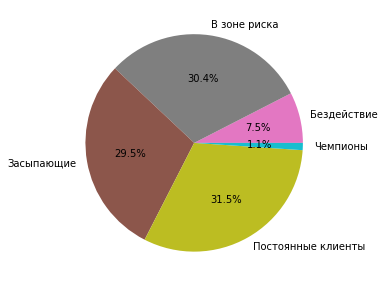

In [338]:
#сегменты клиентов, совершивших покупку до получения смс
income.loc[income['day_incomming'] <0].groupby('Segment').size().plot.pie(figsize=(5, 5),fontsize=10,
                                                                          colors = {'tab:olive','tab:gray', 'tab:pink', 'tab:cyan', 'tab:brown'},
                                                                                  autopct='%1.1f%%')
plt.ylabel('', fontsize=0)
plt.show()

In [316]:
income.groupby('day_incomming').size()

day_incomming
-3       95
-2      511
-1     1171
 0    13252
 1    12402
 2    10612
 3     8844
 4     7418
 5     1536
 6     1139
 7       48
dtype: int64

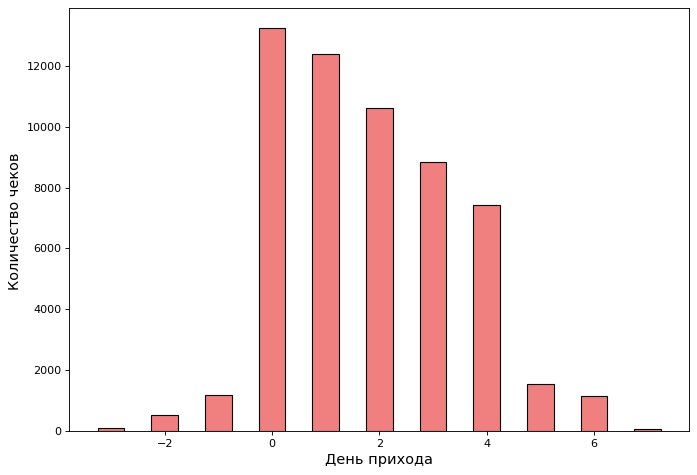

In [291]:
df = (income.groupby('day_incomming').size()).reset_index(name='count')
text = df['day_incomming']
plt.figure(figsize=(10, 7), dpi= 80)
plt.bar(text, df2['count'],width=.5, color = 'lightcoral', edgecolor='black' )
plt.ylabel('Количество чеков ', fontsize=13)
plt.xlabel('День прихода', fontsize=13)
plt.show()